In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# -------------------
# Load and preprocess data
# -------------------

In [ ]:
# RUN PREPROCESSING AND THEN CAN RUN EITHER CROSS VALIDATION OR REGULAR TRAINING

In [ ]:
# PRE-PROCESSING 
df = pd.read_csv("/Users/tobitlouis/Downloads/S27FE-10K.csv")

X = df.drop('realized_volatility', axis=1).values
y = df['realized_volatility'].values

# Log transform target
y = np.log1p(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create overlapping windows
def create_windows(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 60
X_seq, y_seq = create_windows(X_scaled, y, window_size)


Fold 1/5
  R^2: 0.8604, MSE: 0.00000048

Fold 2/5
  R^2: 0.7736, MSE: 0.00000086

Fold 3/5
  R^2: 0.7468, MSE: 0.00000076

Fold 4/5
  R^2: 0.6921, MSE: 0.00000109

Fold 5/5
  R^2: 0.6842, MSE: 0.00000105

✅ Cross-Validation Summary:
  Avg R²:  0.7514 ± 0.0639
  Avg MSE: 0.00000085 ± 0.00000022


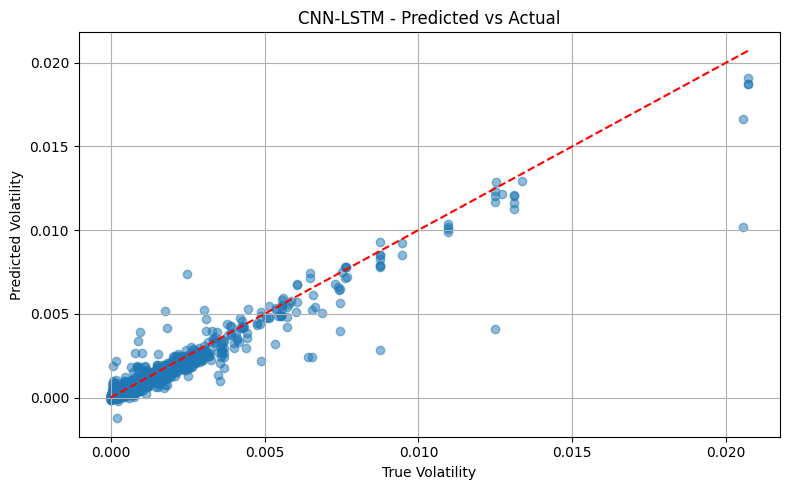

In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
batch_size = 64
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# -------------------
# Define CNN+LSTM model
# -------------------

class CNNLSTMVolatility(nn.Module):
    def __init__(self, num_features, cnn_out_channels=64, lstm_hidden_size=128, lstm_layers=1, dropout_rate=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=cnn_out_channels, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(cnn_out_channels)
        self.relu = nn.ReLU()
        self.cnn_dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
            input_size=cnn_out_channels,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout_rate if lstm_layers > 1 else 0
        )
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.cnn_dropout(x)
        x = x.permute(0, 2, 1)  # (batch, time, channels)
        lstm_out, _ = self.lstm(x)
        final_output = lstm_out[:, -1, :]  # Use last output
        out = self.fc(final_output)
        return out.squeeze()

# -------------------
# Train the model
# -------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMVolatility(num_features=X_seq.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader):.6f}")

# -------------------
# Evaluate the model
# -------------------

model.eval()
y_preds_log, y_trues_log = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        y_preds_log.extend(preds.cpu().numpy())
        y_trues_log.extend(y_batch.numpy())

# Invert log1p
y_preds = np.expm1(y_preds_log)
y_trues = np.expm1(y_trues_log)

mse = mean_squared_error(y_trues, y_preds)
r2 = r2_score(y_trues, y_preds)
print(f"\nFinal Evaluation:")
print(f"  MSE: {mse:.6f}")
print(f"  R^2: {r2:.4f}")

# -------------------
# Plot predictions
# -------------------

plt.figure(figsize=(8, 5))
plt.scatter(y_trues, y_preds, alpha=0.5)
plt.plot([min(y_trues), max(y_trues)], [min(y_trues), max(y_trues)], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("CNN-LSTM - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Cross-validation config
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

r2_scores = []
mse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\nFold {fold+1}/{k_folds}")

    # Split data
    X_train_fold, X_val_fold = X_seq[train_idx], X_seq[val_idx]
    y_train_fold, y_val_fold = y_seq[train_idx], y_seq[val_idx]

    # Convert to DataLoader
    train_dataset = TensorDataset(torch.Tensor(X_train_fold), torch.Tensor(y_train_fold))
    val_dataset = TensorDataset(torch.Tensor(X_val_fold), torch.Tensor(y_val_fold))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    # New model each fold
    model = CNNLSTMVolatility(num_features=X_seq.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train for a few epochs
    for epoch in range(20):  # You can increase this later
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    val_preds_log, val_trues_log = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch)
            val_preds_log.extend(preds.cpu().numpy())
            val_trues_log.extend(y_batch.numpy())

    # Invert log1p
    val_preds = np.expm1(val_preds_log)
    val_trues = np.expm1(val_trues_log)

    mse = mean_squared_error(val_trues, val_preds)
    r2 = r2_score(val_trues, val_preds)
    mse_scores.append(mse)
    r2_scores.append(r2)
    print(f"  R^2: {r2:.4f}, MSE: {mse:.8f}")

# ------------------------
# Final Summary
# ------------------------
print("\n✅ Cross-Validation Summary:")
print(f"  Avg R²:  {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"  Avg MSE: {np.mean(mse_scores):.8f} ± {np.std(mse_scores):.8f}")

# -------------------
# Plot predictions
# -------------------

plt.figure(figsize=(8, 5))
plt.scatter(y_trues, y_preds, alpha=0.5)
plt.plot([min(y_trues), max(y_trues)], [min(y_trues), max(y_trues)], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("CNN-LSTM - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
print(f"MSE: {mean_squared_error(y_trues, y_preds)}")
for true, pred in zip(y_trues[:10], y_preds[:10]):
    print(f"True: {true:.6f}, Pred: {pred:.6f}")


MSE: 2.8774192628588935e-07
True: 0.002471, Pred: 0.007380
True: 0.006011, Pred: 0.005086
True: 0.005153, Pred: 0.005463
True: 0.001711, Pred: 0.001529
True: 0.000572, Pred: 0.000528
True: 0.001681, Pred: 0.001253
True: 0.001494, Pred: 0.001381
True: 0.002204, Pred: 0.002005
True: 0.000571, Pred: 0.000481
True: 0.000530, Pred: 0.000308
